In [1]:
import numpy as np
import pandas as pd
import glob
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mpldates
import matplotlib.gridspec as mplGrid
import bokeh.plotting as bkh
from IPython.display import clear_output

import bokeh.plotting as bkh

# Matplotlib config
#============================
for key in plt.rcParams.keys():
    if 'date.auto' in key:
        plt.rcParams[key] = "%H:%M"
FIG_W = 20
#============================





# Local imports
#------------------------------------------------
import WireDAQ.PandasPlus           # Make sure this import is after pandas
import WireDAQ.Constants as cst
import WireDAQ.NXCALS as nx
import WireDAQ.Spark as spark
import WireDAQ.Parser as parser
import WireDAQ.Efficiency as eff

import sys
sys.path.append('./Executables/py_wireDAQ/fillingstudies/')
from tools_box.analysis import bb_tool_box as bbsc 
#------------------------------------------------

clear_output(wait=False)

# Creating NXCALS variable containers
#------------------------------------------------
wires     = {'B1': [nx.NXCALSWire(loc = loc) for loc in ['L1B1','L5B1']],
             'B2': [nx.NXCALSWire(loc = loc) for loc in ['R1B2','R5B2']]}
beams     = [nx.NXCALSBeam(name) for name in ['B1','B2']]
LHC       = nx.NXCALSLHC()
buckets   = np.arange(3564)
#------------------------------------------------


---
# Loading data locally (NOT saved)
---

In [2]:
# FILL NUMBER
# FILL = 8348 #MD
FILL = 8773

# Variables to be used
#============================================
LHC_vars   = LHC._getVarList(subset=[   'bb_Luminosity',
                                        'Luminosity',
                                        'Xing',
                                        'Fill',
                                        'Bmode',
                                        'betastar'])
beams_vars = sum([beam._getVarList(subset=[ 'bb_Intensity',
                                            'bb_Intensity_B',
                                            'Intensity',
                                            'Intensity_B',
                                            'Nb',
                                            'dBLM_Amp']) for beam in beams],[])


wires_vars = sum([wire._getVarList(subset=[ 'I',
                                            'V']) for wire in wires['B1']+wires['B2']],[])
variables = sorted(LHC_vars+beams_vars+wires_vars)
#============================================


# Loading the data
#============================================
database      = parser.from_NXCALS(fill=FILL,variables = variables)
#============================================

# Extracting filling pattern
#============================================
bb_df_b1,bb_df_b2 = parser.getFillingPattern(database)
#============================================

# Computing intensity avg (every 20 seconds) with calibration BCT_A+BCT_B, aligned with ATLAS
#============================================
BCT_avg  = eff.calibrate_BCT(database,dt=20,calibration_ts = None,reference = LHC['bb_Luminosity']['ATLAS'])
database = pd.concat([database,BCT_avg])
database = database.sort_index()
#============================================

# Computing Lumi tot (ATLAS + CMS bunch by bunch)
#============================================
Lumi_tot = eff.computeLumiTot(database,experiments = ['ATLAS','CMS'])
database = pd.concat([database,Lumi_tot])
database = database.sort_index()
#============================================



2023-05-19 19:05:43,383 [INFO] 
kinit: Pre-authentication failed: Key table file '/home/phbelang/phbelang.keytab' not found while getting initial credentials


Trying to determine YARN usage to make Python work correctly (conf/spark-env.sh)...
Not using YARN
Using virtual venv /home/phbelang/abp/WireDAQ/Executables/py_wireDAQ
PYSPARK_PYTHON == /home/phbelang/abp/WireDAQ/Executables/py_wireDAQ/bin/python
PYSPARK_DRIVER_PYTHON == /home/phbelang/abp/WireDAQ/Executables/py_wireDAQ/bin/python
PYSPARK_DRIVER_PYTHON_OPTS == 


23/05/19 19:05:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/19 19:05:48 WARN DomainSocketFactory: The short-circuit local reads feature cannot be used because libhadoop cannot be loaded.
23/05/19 19:05:49 WARN URLConfigurationSource: No URLs will be polled as dynamic configuration sources.
23/05/19 19:05:49 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
23/05/19 19:05:56 WARN HdfsDatasetCreator: Nothing to be queried as the relevant paths [/project/nxcals/nxcals_pro/data/2/14848/176076/2023/5/15/*.parquet] do not exists
23/05/19 19:08:12 WARN HdfsDatasetCreator: Nothing to be queried as the relevant paths [/project/nxcals/nxcals_pro/data/2/14863/182477/2023/5/15/*.parquet] do not exists


---
# Plotting LHC conditions
---

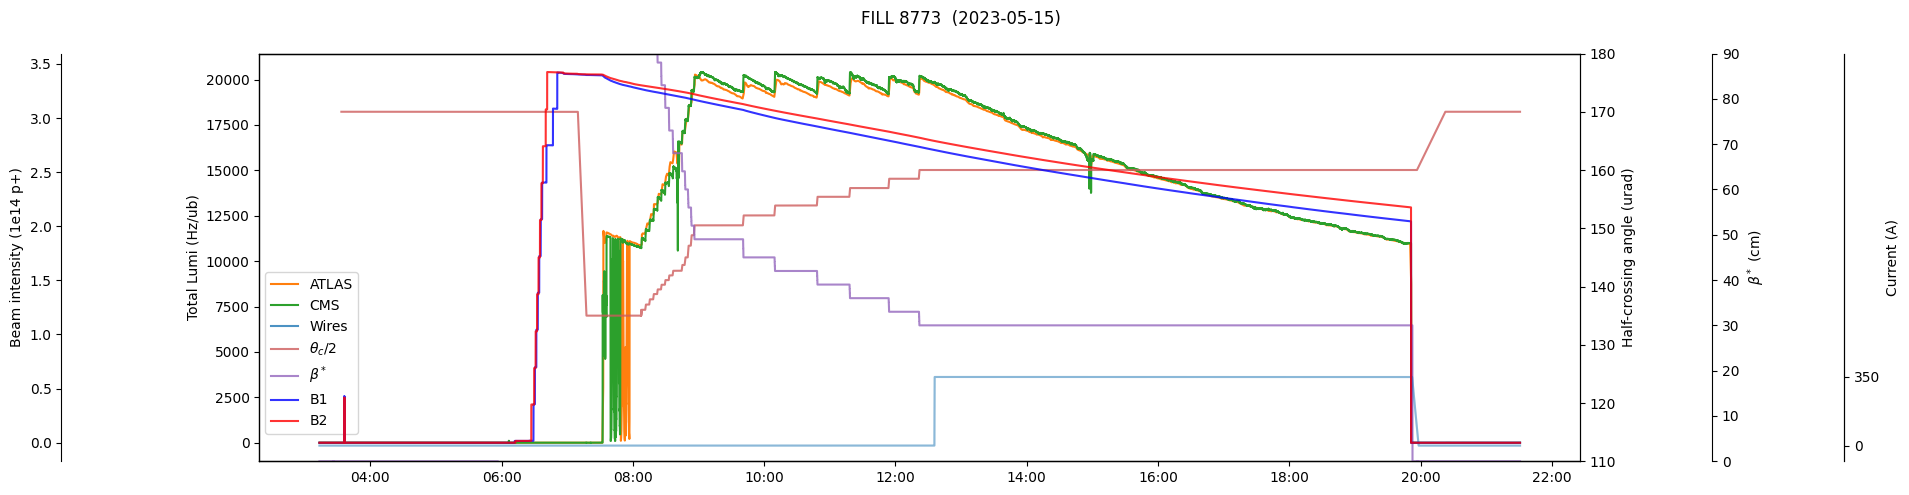

In [5]:
# Plotting

fig  = plt.figure(figsize=(20,5))
plt.suptitle(f'FILL {FILL:d}  ({database["Timestamp"].iloc[0].strftime("%Y-%m-%d")})')

for loc,color in zip(['ATLAS','CMS'],['C1','C2']):
    data = database.set_index('Timestamp')[LHC['bb_Luminosity'][loc]].dropna()

    plt.plot(data.index,data.apply(lambda line: np.sum(line)),color=color,label=loc)
# plt.ylim([-100,2200])


plt.plot([np.nan],[np.nan],color='C0',alpha=0.8,label='Wires')
plt.plot([np.nan],[np.nan],color='indianred',alpha=0.8,label=r'$\theta_c/2$')
plt.plot([np.nan],[np.nan],color='C4',alpha=0.8,label=r'$\beta^*$')

plt.plot([np.nan],[np.nan],color='b',alpha=0.8,label='B1')
plt.plot([np.nan],[np.nan],color='r',alpha=0.8,label='B2')

plt.legend(loc='lower left',bbox_to_anchor=(-0.001,0.05))#, bbox_transform=fig.transFigure)
plt.ylabel('Total Lumi (Hz/ub)');
# plt.xlim([MD_start,MD_stop])
# plt.suptitle(MD_title)

# Plot also wire current and crossing angle
ax = plt.gca()
ax_xing = ax.twinx()
ax_betas = ax.twinx()
ax_betas.spines.right.set_position(("axes", 1.1))
ax_wire = ax.twinx()
ax_wire.spines.right.set_position(("axes", 1.2))

ax_intensity = ax.twinx()
ax_intensity.spines.right.set_position(("axes", 1.2))
ax_intensity.yaxis.set_ticks_position("left")
ax_intensity.yaxis.set_label_position("left")
ax_intensity.spines["left"].set_position(("axes", -0.15))
# ax_intensity.set_frame_on(True)
# ax_intensity.patch.set_visible(False)


plt.sca(ax_wire)
for wire in wires['B2']:
    database.nxPlot('Timestamp',wire.I,color='C0',alpha=0.3)
plt.ylabel('Current (A)')
# plt.ylim([-1500,380])
plt.ylim([-80,2000])
plt.yticks([0,350])

plt.sca(ax_xing)
database.nxPlot('Timestamp',LHC.Xing['IP5'],color='indianred',alpha=0.8)
plt.ylabel('Half-crossing angle (urad)')
plt.ylim([110,180])


plt.sca(ax_betas)
data = database.set_index('Timestamp')[LHC.betastar['IP5']].dropna()
data[(data>90)|(data<0)]=np.nan
plt.plot(data.index,data,color='C4',alpha=0.8)
plt.ylabel(r'$\beta^*$ (cm)')
plt.ylim([0,90])



plt.sca(ax_intensity)
for beam,color in zip(beams,['b','r']):
    data = database.set_index('Timestamp')[beam.Intensity].dropna()
    plt.plot(data.index,data/1e14,color=color,alpha=0.8)
# database.nxPlot('Timestamp',LHC.Xing['IP5'],color='indianred',alpha=0.8)
plt.ylabel('Beam intensity (1e14 p+)')



plt.tight_layout()

In [63]:
import bokeh.plotting as bk
import bokeh.models as bkmod

BOKEH_EXPORT = 'test_bokeh.html'



# Creating Figure
#=====================================
fig = bk.figure(height          = 500, 
                width           = 1500,
                title           = "Overview" + f' FILL {FILL:d}  ({database["Timestamp"].iloc[0].strftime("%Y-%m-%d")})', 
                x_axis_type     = "datetime",
                tools           = "pan,wheel_zoom,box_zoom,reset,save")
fig.xaxis.formatter= bkmod.DatetimeTickFormatter(hourmin = '%H:%M',hours='%H:%M',days='%H:%M',months='%H:%M',years='%H:%M')
fig.add_tools(bkmod.HoverTool(
    tooltips=[('Variable', '$name'),('Time (H:M)','$x{%H:%M}'),('Value','$y')],
    formatters={ "$x": "datetime"}))
#=====================================

# New axis function
#=====================================
def new_axis(fig,axis_name,side='left'):
    fig.extra_y_ranges[axis_name] = bkmod.Range1d(0,1)
    _ax = bkmod.LinearAxis(y_range_name=axis_name)
    fig.add_layout(_ax,side)

    return _ax,axis_name
#=====================================


# Plotting Intensity
#--------------------
for beam,color in zip(beams,['blue','red']):
    data = database.set_index('Timestamp')[beam.Intensity].dropna()
    
    fig.line(data.index,data,color=color,alpha=0.8,legend_label=beam.name,name=f'Intensity {beam.name}')

fig.yaxis.axis_label = "Intensity [1e14 p+]"
fig.xaxis.axis_label = f"Local Time, {database['Timestamp'].iloc[0].strftime('%Y-%m-%d')}"
#--------------------

# Plotting Luminosity
#--------------------
ax,axis_name = new_axis(fig,axis_name='Luminosity',side='left')
max_y = 0
for loc,color in zip(['ATLAS','CMS'],['orange','green']):
    data = database.set_index('Timestamp')[LHC['bb_Luminosity'][loc]].dropna()
    data = data.apply(lambda line: np.sum(line))
    
    fig.line(data.index,data,color=color,alpha=0.8,legend_label=loc,name=f'Luminosity {loc}',y_range_name=axis_name)

    max_y  = np.max((max_y,np.max(data)))

fig.extra_y_ranges[axis_name] = bkmod.Range1d(-0.05*max_y,1.05*max_y)
ax.axis_label = 'Luminosity [Hz/ub]'
#--------------------


# Plotting xing
#--------------------
ax,axis_name = new_axis(fig,axis_name='xing',side='right')


data = database.set_index('Timestamp')[LHC.Xing['IP5']].dropna()
fig.line(data.index,data,color='indianred',alpha=0.8,legend_label="theta/2",name="theta/2",y_range_name=axis_name)

    
fig.extra_y_ranges[axis_name] = bkmod.Range1d(110,180)
ax.axis_label = r"Half-crossing angle [urad]"
#--------------------


# Plotting beta star
#--------------------
ax,axis_name = new_axis(fig,axis_name='beta',side='right')


data = database.set_index('Timestamp')[LHC.betastar['IP5']].dropna()
data[(data>90)|(data<0)]=np.nan
fig.line(data.index,data,color='purple',alpha=0.8,legend_label="beta*",name="beta*",y_range_name=axis_name)

    
fig.extra_y_ranges[axis_name] = bkmod.Range1d(0,90)
ax.axis_label = r"Beta star [cm]"
#--------------------




# Plotting wire current
#--------------------
ax,axis_name = new_axis(fig,axis_name='wire',side='right')

for wire in wires['B2'] :
    data = database.set_index('Timestamp')[wire.I].dropna()

    fig.line(data.index,data,color='teal',alpha=0.8,legend_label="BBCW",name="BBCW",y_range_name=axis_name)

max_y = 2000
fig.extra_y_ranges[axis_name] = bkmod.Range1d(-0.05*max_y,1.05*max_y)
ax.axis_label = r"BBCW Current [A]"
#--------------------









# Legend Options
#=====================================
fig.legend.location     = "top_left"
fig.legend.click_policy = "hide"
#=====================================


# Display options
#=====================================
if BOKEH_EXPORT is None:
    bk.output_notebook()
    bk.show(fig)
else:
    bk.output_file(filename=BOKEH_EXPORT, title="Bokeh Plot")
    bk.save(fig)
#=====================================

In [52]:
x = np.arange(-2*np.pi, 2*np.pi, 0.1)
y = np.sin(x)

p = bk.figure(height=250, title=r"$$\sin(x)\ test\text{Test}$$" )
p.circle(x, y, alpha=0.6, size=7)

# label = bkmod.annotations.labels.Label(
#     text=r"$$y = \sin(x)\$$",
#     x=150, y=130,
#     x_units="screen", y_units="screen",
# )
# p.add_layout(label)

p.yaxis.axis_label = r"$$\sin(x)$$"
p.xaxis.axis_label = r"test"
bk.output_notebook()
bk.show(p)

Loading BokehJS ...

---
# Filling pattern
---

Text(0.5, 25.722222222222214, 'Slot Number')

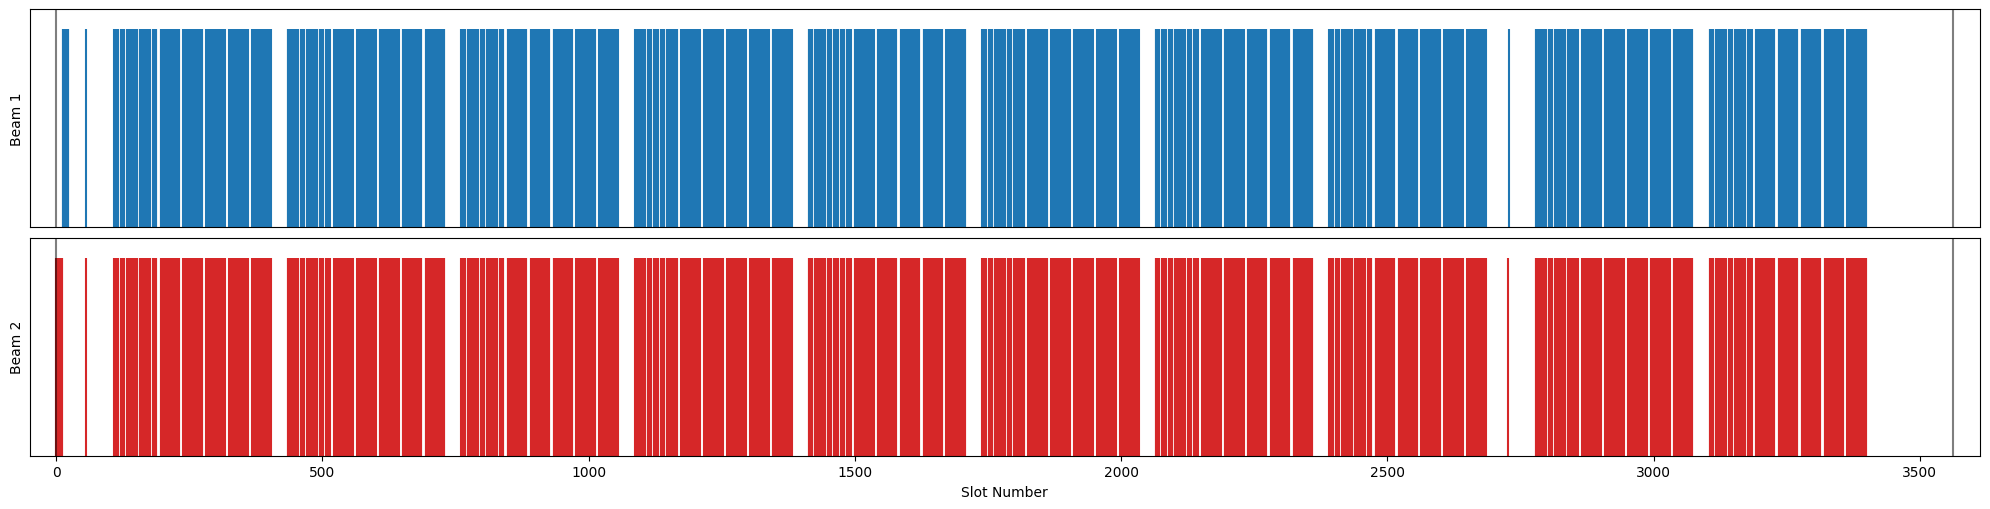

In [9]:

# CREATING FIGURE
#===============================
def Make_Fig(figsize= (25,8)):    
    fig, _axes = plt.subplots(figsize = figsize,ncols=1, nrows=2,gridspec_kw={'height_ratios': [1, 1]})
    plt.subplots_adjust(hspace=0.0)
    axes = {'B1'  :_axes[0],
            'B2'  :_axes[1]}
    
    return fig,axes


fig,axes = Make_Fig(figsize=(20,5))
for beam,bb_df,color in zip(beams,[bb_df_b1,bb_df_b2],['C0','C3']):

    plt.sca(axes[beam.name])
    plt.stem(bb_df.index,np.ones(len(bb_df)),basefmt='none',linefmt=color,markerfmt='none')
         


    plt.ylabel(f'Beam {beam.name[-1]}')

    plt.yticks([])
    plt.xlim([-50,np.max(buckets)+50])
    plt.ylim([0,1.1])

    plt.axvline(0,color='k',ls='-',alpha=0.5)
    plt.axvline(np.max(buckets),color='k',ls='-',alpha=0.5)


plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.05)

plt.sca(axes['B1'])
plt.xticks([])

plt.sca(axes['B2'])
plt.xlabel('Slot Number')
# plt.xlim([0,500])


In [5]:
bb_df_b1

,# of LR in ATLAS,HO partner in ATLAS,BB partners in ATLAS,Positions in ATLAS,# of LR in ALICE,HO partner in ALICE,BB partners in ALICE,Positions in ALICE,# of LR in CMS,HO partner in CMS,BB partners in CMS,Positions in CMS,# of LR in LHCB,HO partner in LHCB,BB partners in LHCB,Positions in LHCB
12,12.0,NaN,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-12.0, -11.0, -10.0, -9.0, -8.0, -7.0, -6.0, ...",35.0,903.0,"[882.0, 883.0, 891.0, 892.0, 893.0, 894.0, 895...","[-21.0, -20.0, -12.0, -11.0, -10.0, -9.0, -8.0...",12.0,NaN,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-12.0, -11.0, -10.0, -9.0, -8.0, -7.0, -6.0, ...",24.0,2682.0,"[2661.0, 2662.0, 2663.0, 2664.0, 2665.0, 2666....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15..."
13,12.0,NaN,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-13.0, -12.0, -11.0, -10.0, -9.0, -8.0, -7.0,...",35.0,904.0,"[883.0, 891.0, 892.0, 893.0, 894.0, 895.0, 896...","[-21.0, -13.0, -12.0, -11.0, -10.0, -9.0, -8.0...",12.0,NaN,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-13.0, -12.0, -11.0, -10.0, -9.0, -8.0, -7.0,...",23.0,2683.0,"[2662.0, 2663.0, 2664.0, 2665.0, 2666.0, 2667....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15..."
14,12.0,NaN,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-14.0, -13.0, -12.0, -11.0, -10.0, -9.0, -8.0...",35.0,905.0,"[891.0, 892.0, 893.0, 894.0, 895.0, 896.0, 897...","[-14.0, -13.0, -12.0, -11.0, -10.0, -9.0, -8.0...",12.0,NaN,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-14.0, -13.0, -12.0, -11.0, -10.0, -9.0, -8.0...",22.0,2684.0,"[2663.0, 2664.0, 2665.0, 2666.0, 2667.0, 2668....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15..."
15,12.0,NaN,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-15.0, -14.0, -13.0, -12.0, -11.0, -10.0, -9....",35.0,906.0,"[891.0, 892.0, 893.0, 894.0, 895.0, 896.0, 897...","[-15.0, -14.0, -13.0, -12.0, -11.0, -10.0, -9....",12.0,NaN,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-15.0, -14.0, -13.0, -12.0, -11.0, -10.0, -9....",21.0,2685.0,"[2664.0, 2665.0, 2666.0, 2667.0, 2668.0, 2669....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15..."
16,12.0,NaN,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-16.0, -15.0, -14.0, -13.0, -12.0, -11.0, -10...",35.0,907.0,"[891.0, 892.0, 893.0, 894.0, 895.0, 896.0, 897...","[-16.0, -15.0, -14.0, -13.0, -12.0, -11.0, -10...",12.0,NaN,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-16.0, -15.0, -14.0, -13.0, -12.0, -11.0, -10...",21.0,NaN,"[2665.0, 2666.0, 2667.0, 2668.0, 2669.0, 2670....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,25.0,3395.0,"[3374.0, 3375.0, 3376.0, 3377.0, 3378.0, 3379....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",28.0,722.0,"[701.0, 702.0, 703.0, 704.0, 705.0, 706.0, 707...","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",25.0,3395.0,"[3374.0, 3375.0, 3376.0, 3377.0, 3378.0, 3379....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",35.0,2501.0,"[2480.0, 2481.0, 2482.0, 2483.0, 2484.0, 2485....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15..."
3396,24.0,3396.0,"[3375.0, 3376.0, 3377.0, 3378.0, 3379.0, 3380....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",27.0,723.0,"[702.0, 703.0, 704.0, 705.0, 706.0, 707.0, 708...","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",24.0,3396.0,"[3375.0, 3376.0, 3377.0, 3378.0, 3379.0, 3380....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",35.0,2502.0,"[2481.0, 2482.0, 2483.0, 2484.0, 2485.0, 2486....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15..."
3397,23.0,3397.0,"[3376.0, 3377.0, 3378.0, 3379.0, 3380.0, 3381....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",26.0,724.0,"[703.0, 704.0, 705.0, 706.0, 707.0, 708.0, 709...","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",23.0,3397.0,"[3376.0, 3377.0, 3378.0, 3379.0, 3380.0, 3381....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",35.0,2503.0,"[2482.0, 2483.0, 2484.0, 2485.0, 2486

In [19]:
bb_df_b1.groupby('Train Length').count()

,Train,Tag,# of LR in ATLAS,HO partner in ATLAS,BB partners in ATLAS,Positions in ATLAS,# of LR in ALICE,HO partner in ALICE,BB partners in ALICE,Positions in ALICE,# of LR in CMS,HO partner in CMS,BB partners in CMS,Positions in CMS,# of LR in LHCB,HO partner in LHCB,BB partners in LHCB,Positions in LHCB
Train Length,,,,,,,,,,,,,,,,,,
1,2,2,2,1,2,2,2,2,2,2,2,1,2,2,2,2,2,2
8,560,560,560,560,560,560,560,364,560,560,560,560,560,560,560,448,560,560
12,12,12,12,0,12,12,12,12,12,12,12,0,12,12,12,4,12,12
36,1800,1800,1800,1800,1800,1800,1800,1352,1800,1800,1800,1800,1800,1800,1800,1319,1800,1800


---
# Efficiency
---

### From BCTF and DBLM

In [6]:
# BCTF
#==============================================================
# Computing efficiency 
BCTF_efficiency = {}
for beam in beams:
    BCTF_efficiency[beam.name]  = eff.compute_BCTF_efficiency(database,beam,dt= 60,smooth_derivative=False)
#==============================================================

# DBLM
#==============================================================
# Computing efficiency 
DBLM_efficiency = {}
for beam in beams:
    DBLM_efficiency[beam.name]  = eff.compute_dBLM_efficiency(database,beam,dt = 10,baseline = None,calib_ROI=None,filled_b_slots=None)
#==============================================================

/home/phbelang/abp/WireDAQ/WireDAQ/Efficiency.py:176: RuntimeWarning: divide by zero encountered in divide
  eta      = cst.SIG_PP*data_L/(-dNdt)
/home/phbelang/abp/WireDAQ/WireDAQ/Efficiency.py:176: RuntimeWarning: divide by zero encountered in divide
  eta      = cst.SIG_PP*data_L/(-dNdt)
/home/phbelang/abp/WireDAQ/WireDAQ/Efficiency.py:288: RuntimeWarning: divide by zero encountered in divide
  lifetime = -data_N/(R_ellN)
/home/phbelang/abp/WireDAQ/WireDAQ/Efficiency.py:288: RuntimeWarning: invalid value encountered in divide
  lifetime = -data_N/(R_ellN)
/home/phbelang/abp/WireDAQ/WireDAQ/Efficiency.py:288: RuntimeWarning: invalid value encountered in divide
  lifetime = -data_N/(R_ellN)


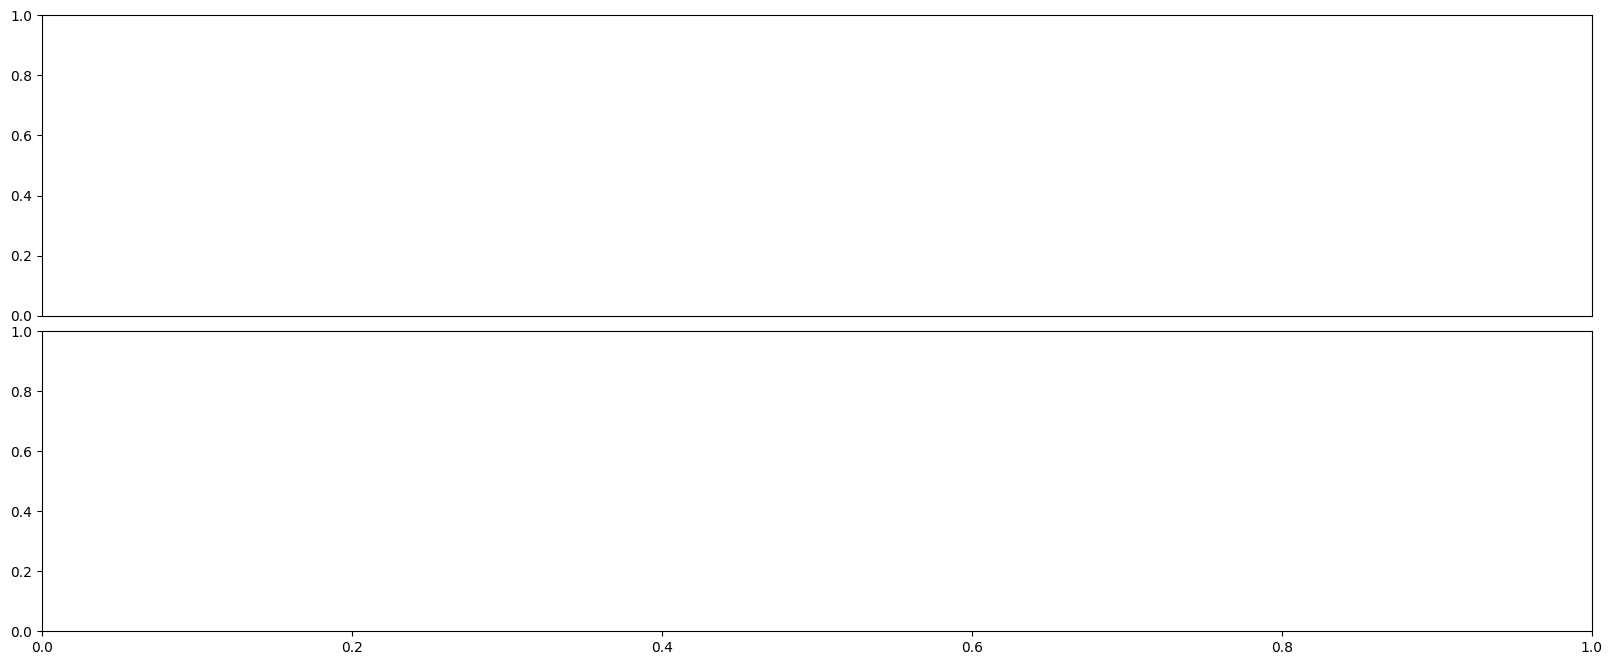

In [ ]:
# CREATING FIGURE
#===============================
def Make_Fig(figsize= (FIG_W,12)):

    fig = plt.figure(figsize=figsize)
    gs = mplGrid.GridSpec(2,1, wspace=0, hspace=0.05, height_ratios=[1,1], figure=fig)
    
    top  = fig.add_subplot(gs[0])
    bot  = fig.add_subplot(gs[1])


    for ax in [top]:
        ax.set_xticks([])

    axes = {'B1' :top,
            'B2' :bot}
    
    return fig,axes






fig,axes = Make_Fig(figsize=(FIG_W,8))

train = bb_df_b1.groupby('Train').get_group(1)
for beam in beams:




chosen_trains_list = [  [1,3,5],
                        [2,3,4,7,8,9,12,13,14]]
for df,datab,bb_df,strength,ax_ref,axlabel,axlabel2,chosen_trains in zip([MD_dblm,FILL8120_dblm],[database,database_FILL8120],[patt.b2.bb_schedule,FILL8120_patt.b2.bb_schedule],[MD_bb_strength,FILL8120_bb_strength],['left','right'],[f'MD8043',f'FILL 8120'],['Machine Development','Operational Fill'],chosen_trains_list):


    #===============================================================================
    # COLORCODED
    #===============================================================================
    
    sc_label = f'Effective number of BBLR'
    # BB_signature = np.nan*np.ones(len(buckets))
    # BB_signature[bb_df.index] =  bb_df['# of LR in ATLAS/CMS'].values
    # BB_signature = strength/np.max(strength) * np.max(bb_df['# of LR in ATLAS/CMS'].values)

    N_LR = bb_df.groupby('Train').get_group(chosen_trains[0])['# of LR in ATLAS/CMS'].values
    loc_max = np.argmax(N_LR)
    BB_signature = strength/strength[loc_max] * N_LR[loc_max]

    _colorby = BB_signature#[choosen_bunches]

    # if axlabel == 'MD8043':
    #     vmin = 15
    #     vmax = 45
    # else:
    #     vmin = 15
    #     vmax = 45
    vmin = 18
    vmax = 42
    cmap = 'cividis'
    #===============================
    
    # CHOOSE BUNCH
    # middles =  list(bb_df[bb_df['Tag'].isin(['22/48','23/48','24/48','25/48','26/48'])].index)
    # tagged = middles

    if axlabel == 'MD8043':
        tagged = bb_df[bb_df['# of LR in ATLAS/CMS']>10].index
    else:
        full_trains = np.tile([2,3,4],8) + np.repeat([0,5,10,15,20,25,30,35],3)

        tagged = bb_df[ (bb_df['# of LR in ATLAS/CMS']>10) & 
                        (bb_df['Tag'].apply(lambda x: float(x.split('/')[0])) <= 30) &
                        (bb_df['Tag'].apply(lambda x: float(x.split('/')[0])) > 3) & 
                        (bb_df.Train.isin(full_trains))].index

    

    



    plt.sca(axes[ax_ref])
    sc = plt.scatter(np.zeros(48),np.nan*np.zeros(48),c = _colorby,vmin=vmin,vmax=vmax,cmap=cmap)
    data   =  df[beam.name].set_index('Timestamp')['eta']
    for _b in tagged:
        color_idx = int(bb_df.loc[_b,'Tag'].split('/')[0])
        plt.plot(data.index,data.apply(lambda line: line[_b]),'-',alpha = 0.3,color=sc.to_rgba(_colorby[color_idx]))

    
    if ax_ref == 'right':
        cbar = plt.colorbar(fraction=0.05,pad=0.02)
        cbar.set_label(sc_label)

    # for ax,axlab in zip(axes,[f'{beam.name} BCTF',f'{beam.name} dBLM']):
    #     plt.sca(ax)
    #     plt.axhline(1,ls='--',color='k')
    #     plt.ylim([0.25,1.1])
    #     # plt.xlim([beta_start,MD_stop])
    #     plt.ylabel(r'$\sigma_{eff}$ (mb)',fontsize=15)

    #     show_wire_on(database,facecolor='k',alpha=0.2,label='Wires ON')
        

    #     # ADJUSTING LEGEND
    #     #====================================
    #     plt.legend()
    #     # handles, labels = plt.gca().get_legend_handles_labels()
    #     line0, = plt.plot([np.nan],[np.nan],'-',alpha=0.5,color=sc.to_rgba(vmax))
    #     line1, = plt.plot([np.nan],[np.nan],'-',alpha=0.5,color=sc.to_rgba(np.mean([vmin,vmax])))
    #     line2, = plt.plot([np.nan],[np.nan],'-',alpha=0.5,color=sc.to_rgba(vmin))

    #     MDplt.add_multi_V_legend([line0,line1, line2],axlab)

    #     #====================================

    plt.axhline(1,ls='--',color='k')
    plt.ylim([0.2,1.09])
    # show_wire_on(df,facecolor='k',alpha=0.2,label='Wires ON')

    if axlabel == 'MD8043':
        plt.xlim([ pd.Timestamp('2022-11-05 21:00:00',tz=TZONE), pd.Timestamp('2022-11-06 01:00:00',tz=TZONE)])
    else:
        plt.xlim([ pd.Timestamp('2022-08-12 21:15:00',tz=TZONE), pd.Timestamp('2022-08-12 23:15:00',tz=TZONE)])
    
    plt.xticks(list(plt.gca().get_xticks())[1:-1])
    
    if axlabel != 'MD8043':
        # get every 30 min
        plt.xticks(list(plt.gca().get_xticks())[::2])
    else:
        plt.yticks([0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

    plt.xlabel(f'Time   [{datab["Timestamp"].iloc[0].strftime("%Y-%m-%d")}]')
    

     # Adding axlabel
    props = dict(boxstyle='round', facecolor='white', alpha=0.95)
    if axlabel == 'MD8043':
        x_text,y_text = 0.03/2,0.97
    else:
        x_text,y_text = 0.03,0.97
    plt.text(x_text,y_text, axlabel2, fontsize=14, 
                                    transform=plt.gca().transAxes,
                                    va='top',ha='left', bbox=props)


    show_wire_on(datab,facecolor='C2',alpha=0.3,zorder=-100,label='Wires ON')

    # xing
    ax_xing = plt.gca().twinx()
    xing_color = 'indianred'
    datab.nxPlot('Timestamp',LHC.Xing['IP5'],lw=2,color=xing_color,alpha=0.8)


        
   

    
    plt.ylim([110+15,180+15])

    if axlabel != 'MD8043':
        ax_xing.set_yticks([])
    else:

        # axes['left'].spines["left"].set_position(("axes", -0.1))

        ax_xing.yaxis.set_ticks_position("left")
        ax_xing.yaxis.set_label_position("left")
        ax_xing.spines["left"].set_position(("axes", -0.1))
        ax_xing.set_frame_on(True)
        ax_xing.patch.set_visible(False)
        ax_xing.set_yticks([130,140,150,160])
        ax_xing.set_ylabel(r'Half-crossing angle, $\theta_c/2$ ($\mu$rad)')
        ax_xing.tick_params(axis='y', colors=xing_color)
        ax_xing.spines['left'].set_color(xing_color)
        axes['left'].set_ylabel(r'Bunch-by-bunch efficiency, $\eta$')


plt.sca(axes['left'])
plt.plot(np.nan,np.nan,color=xing_color,alpha=0.8,label=r'Half-crossing angle, $\theta_c/2$')
# ADJUSTING LEGEND
#====================================
plt.legend()
# handles, labels = plt.gca().get_legend_handles_labels()
line0, = plt.plot([np.nan],[np.nan],'-',alpha=0.5,color=sc.to_rgba(vmax))
line1, = plt.plot([np.nan],[np.nan],'-',alpha=0.5,color=sc.to_rgba(np.mean([vmin,vmax])))
line2, = plt.plot([np.nan],[np.nan],'-',alpha=0.5,color=sc.to_rgba(vmin))

MDplt.add_multi_V_legend([line0,line1, line2],r'Bunch-by-bunch efficiency, $\eta$',framealpha=0.95)

#====================================


plt.tight_layout()